# QPC Scattering matrix

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
%matplotlib inline

## Define all functions and initialize constants

In [2]:
def T(mu):
    """
    This function gen
    erates a transfer matrix for a potential V. 
    """
    # Imaginary identity matrix
    Im = np.zeros((N, N), dtype=complex)
    np.fill_diagonal(Im, 1j)
    v = np.ones(N-1)
    # Tight binding Hamiltonian
    H = np.diag(-v, -1) + np.diag(4*np.ones(N)-mu, 0) + np.diag(-v, 1)
    T11 = -Im + 0.5 * H
    T12 = -0.5 * H
    T21 = -0.5 * H
    T22 = Im + 0.5 * H
    return np.array(np.bmat([[T11, T12], [T21, T22]]))


def S(T):
    """
    This function takes a chemical potential as input and 
    generates the S-matrix and the compontents of S.

    The output-format is matrix-like, as it makes the calculations much easier.
    """
    T11 = T[:N, :N]
    T12 = T[:N, N:2*N]
    T21 = T[N:2*N, :N]
    T22 = T[N:2*N, N:2*N]
    T22_inv = np.linalg.inv(T22)

    S11 = -T22_inv.dot(T21)
    S12 = T22_inv
    S21 = T11 - T12.dot(T22_inv).dot(T21)
    S22 = T12.dot(T22_inv)
    return np.array(np.bmat([[S11, S12], [S21, S22]]))


def add_S(S_1, S_2):
    """
    Adds the old S-matrix S_1 to S_2. Implements equation B6 of "Calculation ... Chalker-Coddington
    network model" by Snyman et al.
    """
    S11_1 = S_1[:N, :N]
    S12_1 = S_1[:N, N:2*N]
    S21_1 = S_1[N:2*N, :N]
    S22_1 = S_1[N:2*N, N:2*N]

    S11_2 = S_2[:N, :N]
    S12_2 = S_2[:N, N:2*N]
    S21_2 = S_2[N:2*N, :N]
    S22_2 = S_2[N:2*N, N:2*N]

    #return S11_1, S12_1, S21_1, S22_1
    
    inv_1 = np.linalg.inv(np.eye(N) - S11_2.dot(S22_1))
    inv_2 = np.linalg.inv(np.eye(N) - S22_1.dot(S11_2))

    S11 = S11_1 + S12_1.dot(inv_1).dot(S11_2).dot(S21_1)
    S12 = S12_1.dot(inv_1).dot(S12_2)
    S21 = S21_2.dot(inv_2).dot(S21_1)
    S22 = S22_2 + S21_2.dot(inv_2).dot(S22_1).dot(S12_2)
    #return S22

    return np.array(np.bmat([[S11, S12], [S21, S22]]))


def generate_S_tot(V, L):
    """ 
    Generates a S-matrix of the combined slices for a potential V.
    """
    S_tot = S(T(V[:, 0]))
    for j in range(1, L):
        S_tot = add_S(S_tot, S(T(V[:, j])))
    return S_tot


def generate_S_tot_opt(V, L):
    """ 
    Generates a S-matrix by multiplying 10 transfer matrices and then adding it to the S_tot matrix.
    In this way we save processor time. (An overall speedup of the whole program of 2x is reached)
    """
    T_tot = T(V[:, 0])
    S_tot = S(T(V[:, 0]))
    assert L % 10 == 0, "L must be a multiple of 10! Or set the argument 'opt' to false."
    for j in range(1, L):
        if j % 10 != 0:
            T_tot = T(V[:, j]).dot(T_tot)
        else:
            S_tot = add_S(S_tot, S(T_tot))
            T_tot = T(V[:, j])

    return S_tot


def smooth_potential(mu, L, xx=1, yy=1, h=1, plot=False):
    """ 
    Generate a smooth potential
    """
    x = np.linspace(-xx, xx, L)
    y = np.linspace(-yy, yy, N)
    X, Y = np.meshgrid(x, y)
    V = -0.5 * h * (np.tanh(Y**2-X**2) + 1) + mu

    if plot == True:
        fig = plt.figure()
        ax = fig.add_subplot(1, 2, 1, projection='3d')
        title = ax.set_title("Potential")
        plt.xlabel('$x$ (L)')
        plt.ylabel('$y$')
        p = ax.plot_surface(X, Y, V)

        ax = fig.add_subplot(1, 2, 2)
        plot = ax.matshow(V)
        fig.colorbar(plot)
        ax.set_xlabel(r'$x$ (L)')
        ax.set_ylabel(r'$y$')
        plt.show()
    return V


def error(S):
    return np.linalg.norm(S.dot(S.T.conj()) - np.eye(len(S)))

In [3]:
## Python constructor methods, export matrices to julia comparison

# defs
N = 40
L = 200
mu = 0.5

# T(mu) export
T_export = T(mu)
#np.savetxt('matrices/T_python.csv', T_export, delimiter=',', fmt='%f')

T_export

array([[ 1.75-1.j, -0.5 +0.j,  0.  +0.j, ..., -0.  +0.j, -0.  +0.j,
        -0.  +0.j],
       [-0.5 +0.j,  1.75-1.j, -0.5 +0.j, ..., -0.  +0.j, -0.  +0.j,
        -0.  +0.j],
       [ 0.  +0.j, -0.5 +0.j,  1.75-1.j, ..., -0.  +0.j, -0.  +0.j,
        -0.  +0.j],
       ...,
       [-0.  +0.j, -0.  +0.j, -0.  +0.j, ...,  1.75+1.j, -0.5 +0.j,
         0.  +0.j],
       [-0.  +0.j, -0.  +0.j, -0.  +0.j, ..., -0.5 +0.j,  1.75+1.j,
        -0.5 +0.j],
       [-0.  +0.j, -0.  +0.j, -0.  +0.j, ...,  0.  +0.j, -0.5 +0.j,
         1.75+1.j]])

In [4]:
# S(T(mu)) export
S_export = S(T_export)
#np.savetxt('matrices/S_python.csv', S_export, delimiter=',', fmt='%f')
S_export

array([[ 7.21746844e-01-4.27470514e-01j, -1.18945020e-01-5.26531105e-02j,
        -3.27481914e-02+5.29458747e-03j, ...,
        -5.63057235e-23-3.60762109e-24j, -1.25915250e-23+7.04044531e-24j,
        -1.84550441e-24+3.06612975e-24j],
       [-1.18945020e-01-5.26531105e-02j,  6.88998652e-01-4.22175926e-01j,
        -1.25207845e-01-4.69653267e-02j, ...,
        -1.89854790e-22-1.25238121e-22j, -5.81512280e-23-5.41491338e-25j,
        -1.25915250e-23+7.04044531e-24j],
       [-3.27481914e-02+5.29458747e-03j, -1.25207845e-01-4.69653267e-02j,
         6.88451388e-01-4.20088921e-01j, ...,
        -3.57709800e-22-8.14435383e-22j, -1.89854790e-22-1.25238121e-22j,
        -5.63057235e-23-3.60762109e-24j],
       ...,
       [-5.63057235e-23-3.60762109e-24j, -1.89854790e-22-1.25238121e-22j,
        -3.57709800e-22-8.14435383e-22j, ...,
        -6.88451388e-01+4.20088921e-01j,  1.25207845e-01+4.69653267e-02j,
         3.27481914e-02-5.29458747e-03j],
       [-1.25915250e-23+7.04044531e-24j, -5.

In [5]:
# add_S export
addS_export = add_S(S_export, S_export)
#np.savetxt('matrices/addS_python.csv', addS_export, delimiter=',', fmt='%f')
addS_export

array([[ 7.47173495e-01-5.75594215e-01j, -1.65006229e-01-1.32397301e-01j,
        -7.51103277e-02-1.15731184e-02j, ...,
         1.27923583e-15-7.24421606e-16j,  3.25377802e-16-5.07931105e-16j,
         4.21397793e-17-2.20028354e-16j],
       [-1.65006229e-01-1.32397301e-01j,  6.72063168e-01-5.87167333e-01j,
        -1.91684191e-01-1.21531755e-01j, ...,
         3.92251118e-15-5.31818186e-16j,  1.32137561e-15-9.44449960e-16j,
         3.25377802e-16-5.07931105e-16j],
       [-7.51103277e-02-1.15731184e-02j, -1.91684191e-01-1.21531755e-01j,
         6.65253528e-01-5.78120793e-01j, ...,
         9.05886031e-15+3.31738733e-15j,  3.92251118e-15-5.31818186e-16j,
         1.27923583e-15-7.24421606e-16j],
       ...,
       [ 1.27923583e-15-7.24421606e-16j,  3.92251118e-15-5.31818186e-16j,
         9.05886031e-15+3.31738733e-15j, ...,
        -6.65253528e-01+5.78120793e-01j,  1.91684191e-01+1.21531755e-01j,
         7.51103277e-02+1.15731184e-02j],
       [ 3.25377802e-16-5.07931105e-16j,  1.

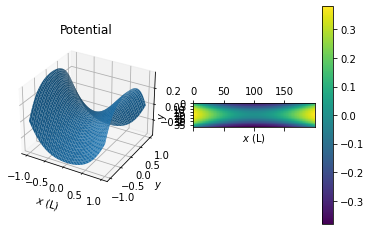

array([[ 0.        , -0.00999841, -0.01988799, ..., -0.01988799,
        -0.00999841,  0.        ],
       [ 0.04980145,  0.03988247,  0.03003244, ...,  0.03003244,
         0.03988247,  0.04980145],
       [ 0.09609434,  0.08642809,  0.0767934 , ...,  0.0767934 ,
         0.08642809,  0.09609434],
       ...,
       [ 0.09609434,  0.08642809,  0.0767934 , ...,  0.0767934 ,
         0.08642809,  0.09609434],
       [ 0.04980145,  0.03988247,  0.03003244, ...,  0.03003244,
         0.03988247,  0.04980145],
       [ 0.        , -0.00999841, -0.01988799, ..., -0.01988799,
        -0.00999841,  0.        ]])

In [6]:
# smooth_potential export
sP_export = smooth_potential(mu, L, xx=1, yy=1, h=1, plot=True)
#np.savetxt('matrices/sP_python.csv', sP_export, delimiter=',', fmt='%f')
sP_export

In [10]:
# generate_S_tot export
genSt_export = generate_S_tot(sP_export, L)
#np.savetxt('matrices/genSt_python.csv', genSt_export, delimiter=',', fmt='%f')
#np.shape(genSt_export)
genSt_export

array([[ 8.18229866e-01-5.35688661e-01j, -1.18335924e-01-1.44547281e-01j,
        -6.52012790e-02-3.82102220e-02j, ...,
         1.20787696e-09-6.17855170e-10j,  6.36458056e-10-3.33066938e-10j,
         2.68564375e-10-1.42800464e-10j],
       [-1.18335924e-01-1.44547281e-01j,  7.47132740e-01-5.81099656e-01j,
        -1.61969619e-01-1.56764781e-01j, ...,
         2.86211191e-09-1.44036927e-09j,  1.50822890e-09-7.76687099e-10j,
         6.36458056e-10-3.33066938e-10j],
       [-6.52012790e-02-3.82102220e-02j, -1.61969619e-01-1.56764781e-01j,
         7.10672332e-01-5.89356259e-01j, ...,
         5.43073828e-09-2.67002687e-09j,  2.86211191e-09-1.44036927e-09j,
         1.20787696e-09-6.17855170e-10j],
       ...,
       [ 1.20787696e-09-6.17855170e-10j,  2.86211191e-09-1.44036927e-09j,
         5.43073828e-09-2.67002687e-09j, ...,
        -7.10672332e-01+5.89356259e-01j,  1.61969619e-01+1.56764781e-01j,
         6.52012790e-02+3.82102220e-02j],
       [ 6.36458056e-10-3.33066938e-10j,  1.

In [11]:
# generate_S_tot_opt export
genStopt_export = generate_S_tot_opt(sP_export, L)
#np.savetxt('matrices/genStopt_python.csv', genStopt_export, delimiter=',', fmt='%f')
genStopt_export

array([[ 8.18155136e-01-5.35486197e-01j, -1.18230669e-01-1.43873775e-01j,
        -6.45900938e-02-3.68564491e-02j, ...,
        -2.71829588e-10-5.43511451e-10j, -1.57864827e-10-2.86850382e-10j,
        -7.09844575e-11-1.21299831e-10j],
       [-1.18230354e-01-1.43873285e-01j,  7.47674957e-01-5.79509702e-01j,
        -1.60361462e-01-1.53799693e-01j, ...,
        -6.24688527e-10-1.27260008e-09j, -3.63286777e-10-6.71893051e-10j,
        -1.63486397e-10-2.84195372e-10j],
       [-6.45897416e-02-3.68562951e-02j, -1.60361825e-01-1.53800958e-01j,
         7.14060631e-01-5.84309923e-01j, ...,
        -1.13415665e-09-2.37414846e-09j, -6.60916769e-10-1.25413859e-09j,
        -2.97785524e-10-5.30666338e-10j],
       ...,
       [-2.71665271e-10-5.44373065e-10j, -6.25108819e-10-1.27125738e-09j,
        -1.13342425e-09-2.37577503e-09j, ...,
        -7.49819435e-01+5.74582389e-01j,  1.34923052e-01+1.50134186e-01j,
         5.23169108e-02+3.62762415e-02j],
       [-1.57794625e-10-2.87317731e-10j, -3.

## Where the magic happens

##### Calculate the T_tot matrix, the outcomming waves and find the coefficients

The waves are normalized by the current $<I>$. As the current operator is now $\sigma_z$, we divide by the norms.

In [17]:
def solve(mu, V, L, i, opt):
    if opt == True:
        S_tot = generate_S_tot_opt(V, L)
    else:
        S_tot = generate_S_tot(V, L)
    S11 = S_tot[:N, :N]
    S12 = S_tot[:N, N:2*N]
    S21 = S_tot[N:2*N, :N]
    S22 = S_tot[N:2*N, N:2*N]

    # find the eigenvalues and vectors
    eig_val, eig_vec = np.linalg.eig(T(mu))
    eig_val_round = np.round(eig_val, 10)
    #return eig_val, eig_vec

    # get indices of the forward and backward propagating waves and the
    # evanescent growing and decaying waves
    idx_R = np.where(eig_val_round.imag > 0.)[0]  # waves that propagate right
    idx_L = np.where(eig_val_round.imag < 0.)[0]  # waves that propagate left
    idx_evan = np.where(eig_val_round.imag == 0)[0]  # evanescent waves
    # evanescent growing waves
    idx_grow = np.where(np.abs(eig_val_round[idx_evan]) > 1)[0]
    # evanescent decaying waves
    idx_dec = np.where(np.abs(eig_val_round[idx_evan]) < 1)[0]

    psi_R = eig_vec[:, idx_R]
    psi_L = eig_vec[:, idx_L]
    ev_dec = eig_vec[:, idx_evan][:, idx_dec]
    ev_grow = eig_vec[:, idx_evan][:, idx_grow]

    # normalize the wavefunctions
    psi_R_norm = np.linalg.norm(
        psi_R[N:2*N], axis=0)**2 - np.linalg.norm(psi_R[:N], axis=0)**2
    psi_L_norm = np.linalg.norm(
        psi_L[:N], axis=0)**2 - np.linalg.norm(psi_L[N:2*N], axis=0)**2
    psi_R /= np.sqrt(np.abs(psi_R_norm))
    psi_L /= np.sqrt(np.abs(psi_L_norm))

    # generate and solve the system of equations for the matching conditions
    U_L_top = np.hstack((-S12.dot(psi_R[N:2*N]), ev_grow[N:2*N] - S11.dot(ev_grow[:N]),
                         psi_L[N:2*N] - S11.dot(psi_L[:N]), -S12.dot(ev_dec[N:2*N])))
    
    #return U_L_top
    U_L_bot = np.hstack((psi_R[:N] - S22.dot(psi_R[N:2*N]), -S21.dot(ev_grow[:N]),
                         -S21.dot(psi_L[:N]), ev_dec[:N] - S22.dot(ev_dec[N:2*N])))

    U_L = np.vstack((U_L_top, U_L_bot))

    U_R_top = S11.dot(psi_R[:N]) - psi_R[N:2*N]
    U_R_bot = S21.dot(psi_R[:N])
    U_R = np.vstack((U_R_top, U_R_bot))

    # find the coefficients and put them in seperate matrices
    coeff = np.dot(np.linalg.inv(U_L), U_R)

    N_in = psi_L.shape[1]  # number of incomming waves
    N_ev = ev_dec.shape[1]  # number of evanescent waves

    t_matrix = coeff[:N_in, :]
    alpha = coeff[N_in:N_in+N_ev, :]
    r = coeff[N_in+N_ev:2*N_in+N_ev, :]
    beta = coeff[2*N_in+N_ev:2*N_in+2*N_ev, :]

    G = np.linalg.norm(t_matrix)**2

    test = np.sum(np.abs(t_matrix)**2+np.abs(r)**2, axis=0)
    test2 = np.round(np.sum(test)/len(test), 5)
    if test2 != 1:
        print("Unitarity not preserved at " +
              str(i) + " for mu, L " + str(mu) + str(L))

    return G, t_matrix, alpha, r, beta

In [18]:
# solve test
V = smooth_potential(mu, L, xx=1, yy=1, h=.6, plot=False)
a, b = solve(mu, V, L, mu, opt = False)

#np.savetxt('matrices/eigvalPY.csv', a, delimiter=',', fmt='%f')
#np.savetxt('matrices/eigvecPY.csv', b, delimiter=',', fmt='%f')

ValueError: too many values to unpack (expected 2)

## Plot the potential

In [ ]:
en = 0.5
L = 200
N = 40
V = smooth_potential(en, L, xx=1, yy=1, h=.6, plot=True)
#a = solve(en, V, L, en, opt = True)
#np.sum(np.abs(a))

# Quantized Conductance of a quantum point contact (QPC)

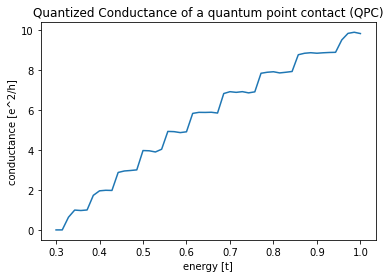

In [21]:
N = 40 # number of transverse lattice points
L = 200 # length of the scattering region

G = []

energies = np.linspace(.3, 1, 50)
for en in energies:
    V = smooth_potential(en, L, xx=1, yy=1, h=.6, plot=False)
    G.append(solve(en, V, L, en, opt = True)[0])
    
plt.plot(energies, G)
plt.title('Quantized Conductance of a quantum point contact (QPC)')
plt.xlabel('energy [t]')
plt.ylabel('conductance [e^2/h]')
plt.show()

np.savetxt('matrices/QGpy.csv', G, delimiter=',', fmt='%f')

## Leads become available

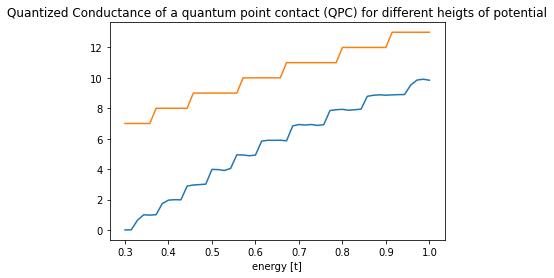

In [43]:
G2 = []
for en in energies:
    V = smooth_potential(en, L, xx=1, yy=1, h=0, plot=False)
    G2.append(solve(en, V, L, en, opt = True)[0])

plt.title('Quantized Conductance of a quantum point contact (QPC) for different heigts of potential')
plt.xlabel('energy [t]')
plt.plot(energies, G, energies, G2)
plt.show()

# Anderson Localization

In [8]:
%%capture --no-stdout
from scipy.optimize import curve_fit
N = 20
G = []
lengths = np.arange(300, 1000, 20)
mu = 0.1
for L in lengths:
    V = np.random.rand(N,L)
    G.append(solve(mu, V, L, L, opt = False)[0])

def func(x, a, b, c):
    return a * np.exp(-b * x) + c

popt, pcov = curve_fit(func, lengths, G)

plt.figure()

plt.plot(lengths, G, 'ko', label="Original Noised Data")
plt.plot(lengths, func(lengths, *popt), 'r-', label="Fitted Curve")
plt.xlabel("length [L]")
plt.ylabel("conductance [e^2/h]")
plt.legend()
plt.show()

ValueError: shapes (20,20) and (0,0) not aligned: 20 (dim 1) != 0 (dim 0)